# LISST-100 data processing notebook

The following notebook was developed by the Suspended Material and Seabed Monitoring and Modelling group (SUMO) from the Institute of Natural Sciences, Belgium. It aims at providing a standard protocol to process data collected in-situ with a LISST-100 instrument placed on a rosette profiling the water column. To use this notebook, simply import the data previously converted to asc by the LISST-SOPv5 software, run the cells containing code and inspect the results obtained. The graphs can then be saved as jpg and the processed data as csv.

In this notebook, the LISST-100 data processing has been divided into three stages:
1. *ASC data generation*: The first stage, during which the raw data is converted from .dat to .asc, requires the use of the LISST-SOPv5 software. 
2. *Data import & flagging*: This notebook can then be used to carry out the second stage, which includes the import and pre-processing of the data (i.e. date conversion, data flagging). At the end of this stage, the user can save the full dataset with a flagging system and dates as datetime. 
3. *Statistics computation & visualization*: The third stage performs the calculation of different statistical parameters on a clean dataset (after filtrating data above a certain flag value), such as mean particle diameter, D10, D50, D90 and distribution characteristics, and displays outputs as graphs. The clean dataset as well as the graphs can be saved. Data are also merged per cast, allowing the user to save a csv containing mean values of each cast.

**Important!** Before starting the processing, make sure that all the necessary packages and libraries are installed on your computer and that you run the cell below to import everything that is required. Before running this cell, make sure you've installed all the necessary packages on your computer. To do that, you can run the following line in the prompt:
- pip install tk pandas numpy matplotlib seaborn scipy

In [36]:
                                                    ## Cell 01 ##
import os
import ipywidgets as widgets
from IPython.display import display
import shutil
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.filedialog import asksaveasfilename
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
                                                        ###

## Stage 1: Conversion of dat files to asc files

In this stage, the conversion of the raw LISST-100 data is performed using the LISST-SOPv5 software, which can be downloaded freely on https://www.sequoiasci.com/product/lisst-100x/. The different steps to be perfomed are explained in more details in this section. 

1. Open .dat file with corresponding background file (.asc) and select output directory. Once that is done, a graph will appear showing the different rings (from 1 to 32) through time, as well as another graph showing the auxiliary parameters (if any) through time. In your output directory, you will notice that new files have been added: a .psd and a .log files (for both round particles and random shapes (rs)).

2. After inspection of the data, you can then click on the "Process File" button. Be aware that depending on the size of your data, that operation might take a long time. 

## Stage 2: Data pre-processing

#### Stage 2 - Step 1 : Enter metadata

In this cell, the user will be asked to enter the campaign identification code, year at which the data were collected, the name of the sampling location and coordinates in decimal degrees (XX.XXXXX). Press enter after each input.
**Important!** Avoid using "/" in the campaign identification code, as it might create issues when saving the data.

In [2]:
                                                    ## Cell 02 ##
campaign_code = input("Enter the campaign identification code: ")
year = int(input("Enter the year of the data: "))
location = input("Enter the name of the sampling location: ")
latitude = input("Enter the latitude of the data: ")
longitude = input("Enter the longitude of the data: ")

# Choice of path reduction module
path_length_dropdown = widgets.Dropdown(
    options=['50 mm path length (no PRM)', '25 mm path length', '10 mm path length', '5 mm path length'],
    value='50 mm path length (no PRM)',
    description='Path length (RBINS default is 25 mm):',
    style={'description_width': 'initial'} 
)
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global selected_path_length
        selected_path_length = change['new']
        print(f"Selected path reduction module: {selected_path_length}")
path_length_dropdown.observe(on_change)
display(path_length_dropdown)
                                                        ###

Enter the campaign identification code: ST2317
Enter the year of the data: 2023
Enter the name of the sampling location: Codevco
Enter the latitude of the data: x
Enter the longitude of the data: x


Dropdown(description='Path length (RBINS default is 25 mm):', options=('50 mm path length (no PRM)', '25 mm pa…

Selected path reduction module: 25 mm path length


#### Stage 2 - Step 2 : Data import & formatting

Upon running this cell, a new window should automatically open and invite the user to select the asc file to be processed. Be aware that this window might open in the background and could be hidden under the current window. Once imported, the data will be attributed column names, campaign identification number, sampling location and year (as inserted by the user in the cell above). In addition to that, day_hour and minute_second columns will be converted to jday and datetime values. A new column containing a flag value (set by default to zero at this step) will be added at the end of the dataset. Finally, a corrected beam attenuation is computed using the path reduction module selected by the user.

The dataset will be displayed upon running the cell, enabling the user to check that columns and values were assigned correctly and that the calculated date and time of the data correspond to the actual sampling time.

In [16]:
                                                    ## Cell 03 ##
# Open a window to select input file
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename(title="Select an ASC file", filetypes=[("ASC files", "*.asc")])
directory_path = os.path.dirname(file_path)

output_directory = f"{directory_path}/LISST-100-{campaign_code}-{location}-processed"
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
    print(f'Existing output folder removed at: {output_directory}')
os.makedirs(output_directory)
print(f'Output folder created at: {output_directory}')

if file_path:  
    try:
        data = pd.read_csv(file_path, header=None, sep=" ")
        print("File successfully loaded!") 
        data = data.iloc[:, 0:-1]
        # Add column names
        data.columns = ["2.72","3.2","3.78","4.46","5.27","6.21","7.33","8.65","10.2","12.1","14.2","16.8","19.8","23.4","27.6","32.5","38.4","45.3","53.5","63.1","74.5","87.9","104","122","144","170","201","237","280","331","390","460","laser_transmission_sensor_mW","battery_voltage_V","external_input_1_mW","laser_reference_sensor_mW","pressure_m","temperature_C","day_hour","minute_second","optical_transmission","beam_attenuation_m"]
        # Correction of volume concentrations based on path reduction module
        if selected_path_length == 'None (50 mm path length)':
            multiplication_factor = 1
        elif selected_path_length == '25 mm path length':
            multiplication_factor = 2
        elif selected_path_length == '10 mm path length':
            multiplication_factor = 5
        elif selected_path_length == '5 mm path length':
            multiplication_factor = 10
        volume_concentration_columns = ['2.72', '3.2', '3.78', '4.46', '5.27', '6.21', '7.33', '8.65', 
                  '10.2', '12.1', '14.2', '16.8', '19.8', '23.4', '27.6', '32.5', 
                  '38.4', '45.3', '53.5', '63.1', '74.5', '87.9', '104', '122', 
                  '144', '170', '201', '237', '280', '331', '390', '460']
        data[volume_concentration_columns] *= multiplication_factor
        # Adjust beam attenuation based on path reduction module
        data['corrected_beam_attenuation_m'] = data['beam_attenuation_m'] * multiplication_factor
        # Add campaign identification number, sampling location name, latitude, longitude and year
        data['campaign'] = campaign_code
        data['location'] = location
        data['latitude'] = latitude
        data['longitude'] = longitude
        data['year'] = year
        # Calculate datetime
        data['jday'] = round((data['day_hour'] / 100),0)
        start_of_year = datetime(year, 1, 1)
        data['datetime'] = pd.to_datetime(data['jday'].apply(lambda x: start_of_year + timedelta(days=x-1))) \
    + pd.to_timedelta((data['day_hour'] % 100), unit='h') \
    + pd.to_timedelta(data['minute_second'] // 100, unit='m') \
    + pd.to_timedelta(data['minute_second'] % 100, unit='s')
        data['flag'] = 0
        # Compute sampling start and stop datetime
        sampling_start = data['datetime'].min()
        sampling_stop = data['datetime'].max()
        # Display output
        print(f'Data were collected at {location} between {sampling_start} and {sampling_stop} during campaign {campaign_code}.')
        display(data)
    except Exception as e:
        print(f"Error reading the file: {e}")
else:
    print("No file selected")
                                                        ###

Existing output folder removed at: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-100x/test_sample_to_delete/LISST-100-ST2317-Codevco-processed
Output folder created at: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-100x/test_sample_to_delete/LISST-100-ST2317-Codevco-processed
File successfully loaded!
Data were collected at Codevco between 2023-09-14 09:54:05 and 2023-09-14 14:09:19 during campaign ST2317.


,2.72,3.2,3.78,4.46,5.27,6.21,7.33,8.65,10.2,12.1,...,beam_attenuation_m,corrected_beam_attenuation_m,campaign,location,latitude,longitude,year,jday,datetime,flag
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:05,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:06,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:07,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:08,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:15,0
15315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:16,0
15316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:17,0
15317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:18,0


#### Stage 2 - Step 3: Flagging of the data

In this cell, flagging operations are performed as follows:
1. A first check is done on the **reference laser**, if values are below 0.2 mW, this indicates that the laser is likely not working properly. Quality flags will be assigned to 1 if data are above this value and to 3 if not (see flags meaning below). If more than 10% of the data present such a low value, a warning message will be displayed.  
2. Data out of the water are flagged with the value of 4 (rows where the beam attenuation is equal to zero). The **beam attenuation** corresponds to the loss of light intensity when a laser beam passes through water, due to both absorption and scattering. Higher attenuation values typically indicate more turbid water. 
3. The **laser transmission** values are checked. This indicates how much of the laser light has passed through water without being absorbed or scattered. A value of 100% indicates that there has been no light loss through the sample (either water without particles or air) while values below indicate scattering and absorption (which is expected in seawater). Values above 100%, however, indicate a sensor malfunction or miscalibration. If most data (>50%) are above 100%, then a warning message is generated. Data above 100 are flagged with the value of 3. 
4. The **optical transmission** is checked: values should be ranging between 0 and 1. Values outside that range should be discarded (flag 4). However, values above 0.98-0.995 reflect extremely clear water conditions, meaning a low signal-to-noise ratio (flag 3, to be taken with caution. Above that range, values should be discarded), whereas values below 0.10 reflect very turbid data and should be discarded. 
5. Finally, a flag of 3 is attributed to **outliers** detected based on the total volume concentration calculated.

Once the flagging has been performed, a graph allows the user to visualize the quality of the data. The complete flagged dataset is automatically saved in the output directory selected by the user at the beginning of this notebook. In stage 3, a cell then allows to filter out all the data with a quality flag equal or higher than 4.

Quality flags are defined following the quality flags standards defined by the NERC Environmental Data Service of the British Oceanographic Data Centre (https://vocab.nerc.ac.uk/collection/L20/current/):
0: No quality control
1: Good value
2: Probably good value
3: Probably bad value
4: Bad value
5: Changed value
6: Value below detection
7: Value in excess
8: Interpolated value
9: Missing value

Number of outliers detected: 17
Flagging has been successfully performed on the complete dataset:


,2.72,3.2,3.78,4.46,5.27,6.21,7.33,8.65,10.2,12.1,...,campaign,location,latitude,longitude,year,jday,datetime,flag,total_volume_concentration,is_outlier
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:05,4,0.0,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:06,4,0.0,False
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:07,4,0.0,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:08,4,0.0,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 09:54:09,4,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:15,4,0.0,False
15315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:16,4,0.0,False
15316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:17,4,0.0,False
15317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,ST2317,Codevco,x,x,2023,257.0,2023-09-14 14:09:18,4,0.0,False


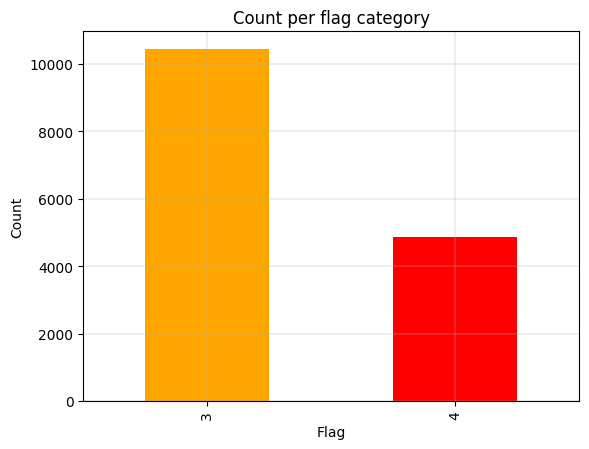

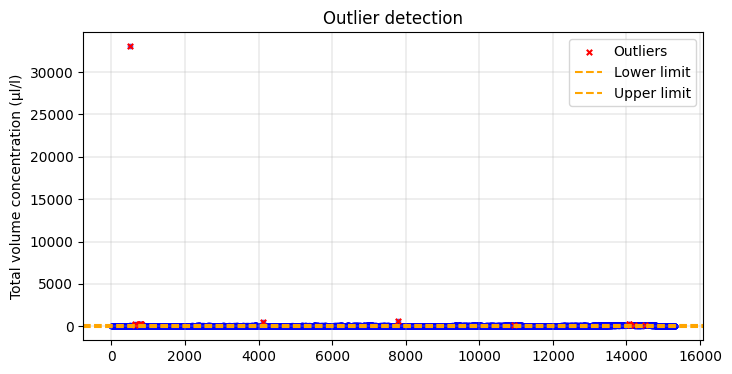

File saved to C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-100x/test_sample_to_delete/L2570954.asc


In [17]:
                                                    ## Cell 04 ##
# Step 1: Flagging based on reference_laser
data['flag'] = data.apply(lambda row: max(row['flag'], 1) if row['laser_reference_sensor_mW'] > 0.02 else max(row['flag'], 3), axis=1)
reference_below_thsld = (data['laser_reference_sensor_mW'] <= 0.02).sum() / len(data) * 100
if reference_below_thsld > 20:  # If more than 20% of the data are below 0.02 mW
    messagebox.showwarning("Laser should be checked", 
                           f"Warning: {reference_below_thsld:.0f}% of the data have a laser reference value below 0.02 mW. "
                           "Please check laser.")

# Step 2: Beam attenuation flagging
data['flag'] = data.apply(lambda row: max(row['flag'], 4) if row['beam_attenuation_m'] <= 0 else row['flag'], axis=1)

# Step 3: Laser transmission flagging
data['flag'] = data.apply(lambda row: 3 if row['laser_transmission_sensor_mW'] > 100 and row['flag'] < 3 else row['flag'], axis=1)
underwater_data = data[data['beam_attenuation_m'] > 0]
above_100_percent = (underwater_data['laser_transmission_sensor_mW'] > 100).sum() / len(underwater_data) * 100
above_100_percent = (data['laser_transmission_sensor_mW'] > 100).sum() / len(data) * 100
if above_100_percent > 50:  # If more than 50% of the data are above 100%
    messagebox.showwarning("Recalibration Needed", 
                           f"Warning: {above_100_percent:.0f}% of the underwater data are above 100% transmission. "
                           "Please recalibrate the sensor.")
    
# Step 4: Optical transmission flagging
data['flag'] = data.apply(lambda row: 3 if row['optical_transmission'] > 0.98 and row['optical_transmission'] < 0.995 and row['flag'] < 3 else row['flag'], axis=1)
data['flag'] = data.apply(lambda row: 4 if row['optical_transmission'] >= 0.995 and row['flag'] < 4 else row['flag'], axis=1)
data['flag'] = data.apply(lambda row: 4 if row['optical_transmission'] <= 0.10 and row['flag'] < 4 else row['flag'], axis=1)
    
# Step 5: Outlier detection using IQR
volume_columns = ['2.72', '3.2', '3.78', '4.46', '5.27', '6.21', '7.33', '8.65', 
                  '10.2', '12.1', '14.2', '16.8', '19.8', '23.4', '27.6', '32.5', 
                  '38.4', '45.3', '53.5', '63.1', '74.5', '87.9', '104', '122', 
                  '144', '170', '201', '237', '280', '331', '390', '460']

data['total_volume_concentration'] = data[volume_columns].sum(axis=1)
Q1 = data['total_volume_concentration'].quantile(0.25)
Q3 = data['total_volume_concentration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['flag'] = data.apply(lambda row: 3 if row['total_volume_concentration'] < lower_bound or row['total_volume_concentration'] > upper_bound else row['flag'], axis=1)
data['is_outlier'] = (data['total_volume_concentration'] < lower_bound) | (data['total_volume_concentration'] > upper_bound)
outlier_count = data['is_outlier'].sum()
print(f'Number of outliers detected: {outlier_count}')
    
# Warning message quality flags
percentage_high_flags = (data['flag'] >= 3).sum() / len(data) * 100
if percentage_high_flags > 75:  # If more than 75% of the data have a quality flag of 3 or higher
    messagebox.showwarning("Unsatisfactory data quality", 
                           f"Warning: {percentage_high_flags:.0f}% of the data have a quality flag above 3. "
                           "Data should be used with caution.")
    
# Output
print('Flagging has been successfully performed on the complete dataset:')
display(data)

flag_counts = data['flag'].value_counts().sort_index()
colors = {1: 'green', 2: 'yellow', 3:'orange', 4: 'red'}
fig, ax = plt.subplots()
flag_counts.plot(kind='bar', color=[colors.get(flag, 'blue') for flag in flag_counts.index], ax=ax)
ax.grid(axis='both', which='both', linewidth=0.3)
ax.set_title("Count per flag category")
ax.set_xlabel("Flag")
ax.set_ylabel("Count")
plt.show()

# Visualizing outliers
plt.figure(figsize=(8, 4))
plt.scatter(data.index, data['total_volume_concentration'], label='', color='blue', s=10, alpha=0.5)
plt.scatter(data[data['is_outlier']].index, data[data['is_outlier']]['total_volume_concentration'], 
            label='Outliers', color='red', marker='x', s=15)
plt.axhline(lower_bound, color='orange', linestyle='--', label='Lower limit')
plt.axhline(upper_bound, color='orange', linestyle='--', label='Upper limit')
plt.grid(axis='both', which='both', linewidth=0.3)
plt.title('Outlier detection')
plt.xlabel('')
plt.ylabel('Total volume concentration (µl/l)')
plt.legend()
plt.show()

data.drop(columns=['total_volume_concentration'], inplace=True)

# Save as csv
data_path = f"{output_directory}/{campaign_code}-{location}-LISST100-full-data.csv"
if data_path:
    data.to_csv(data_path, index=False)
    print(f"File saved to {file_path}")
else:
    print("Save operation cancelled.")
                                                        ###

## Stage 3: Statistics computation & visualization

#### Stage 3 - Step 1: Statistics computation

By running this cell, a series of statistics are calculated on the full dataset. This includes:
1. **Total volume concentration**: This sums up the volume concentration of each grain size class per row.
2. **Relative volume concentration**: This calculates the percentage that each class represents compared to the total volume concentration.
3. **Mean diameter**: This corresponds to the mean diameter of particles in each row weighted by their volume concentration and normalized by the total volume concentration.
4. **D10, D50, D90 values**: These represent the diameter below which 10%, 50% or 90% of the volume of the data are found. The D10 helps characterizing the finer fraction of the sample, the D50 corresponds to the median diameter and the D90 characterizes the coarser sediment fraction. These values are calculated based on the cumulative distribution.
5. **Span**: It is a measure of the sorting of particle sizes, as a normalized measure of the distribution spread around the median particle size, showing the relative range of the middle 80% of the particle size distribution. Small values indicate good sorting (close to 1) while a larger span indicates poor sorting of the particles.
6. **Standard deviation**: It measures the average dispersion of particle sizes from the mean, a greater standard deviation shows greater variability around the mean with possible outliers or tails. If the span and standard deviation are low, it shows a uniform distribution; if the span is moderate but the standard deviation is high, it shows a moderate spread with outliers; and if the span and standard deviation are high, it shows a wide distribution.
7. **Mode**: The mode is the particle size that has the largest volume of the distribution (peak in the distribution).
8. **Peaks in the distribution**: It identifies peaks in the particle size distribution.

The particle size distribution combined with the cumulative volume concentration is displayed upon running of this cell as well as a table with the mean value of all the calculated parameters. The graph and updated complete clean dataframe are automatically saved in the directory selected by the user.

Statistics have been successfully computed


,2.72,3.2,3.78,4.46,5.27,6.21,7.33,8.65,10.2,12.1,...,460_%,mean_diameter_um,D10_um,D50_um,D90_um,span,std_dev_um,mode_um,peaks,cast
513,7.12088,2.870700,0.921646,0.297726,0.171914,0.279974,0.613128,0.726412,0.913216,1.305070,...,5.930018,238.263748,16.80,280.0,390.0,1.332857,143.947020,331.00,"[12.1, 16.8, 27.6, 144.0, 331.0]",A
514,6.65700,2.777140,0.934894,0.319186,0.193705,0.318252,0.679022,0.789028,0.969562,1.364092,...,1.680228,173.676969,3.78,170.0,331.0,1.924824,133.447485,331.00,"[12.1, 16.8, 170.0, 331.0]",A
515,6.20142,2.601380,0.882004,0.305768,0.190198,0.317604,0.674484,0.768794,0.929186,1.279692,...,8.175758,85.207885,2.72,27.6,280.0,10.046377,129.849772,2.72,"[12.1, 16.8, 27.6, 53.5, 122.0]",A
516,5.47990,2.491080,0.938862,0.364250,0.241542,0.390464,0.774110,0.859502,0.998730,1.313834,...,11.837185,122.635417,2.72,53.5,460.0,8.547290,152.694484,460.00,"[12.1, 16.8, 27.6, 144.0]",A
517,5.00538,2.355080,0.928272,0.377820,0.258372,0.411470,0.785636,0.859366,0.994898,1.304294,...,18.289022,132.602895,2.72,38.4,460.0,11.908333,173.025074,460.00,"[12.1, 16.8, 27.6, 53.5, 122.0]",A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14866,4.31188,1.862852,0.658638,0.233810,0.142430,0.225268,0.465862,0.547266,0.669012,0.914118,...,0.091645,46.454113,2.72,38.4,104.0,2.637500,42.185172,2.72,"[12.1, 74.5]",E
14867,4.57820,1.919792,0.653462,0.223394,0.133435,0.214516,0.454836,0.535816,0.661774,0.924832,...,0.146582,45.101715,2.72,32.5,104.0,3.116308,43.435416,2.72,"[12.1, 19.8, 63.1]",E
14868,5.04242,1.987552,0.621856,0.193561,0.108462,0.176388,0.394836,0.483288,0.629298,0.933688,...,0.048375,39.452384,2.72,27.6,87.9,3.086232,38.771997,2.72,"[19.8, 53.5]",E
14869,5.63722,2.134120,0.634158,0.186253,0.100720,0.166428,0.386966,0.480438,0.630880,0.945208,...,0.081466,42.650573,2.72,32.5,104.0,3.116308,40.115523,2.72,[63.1],E


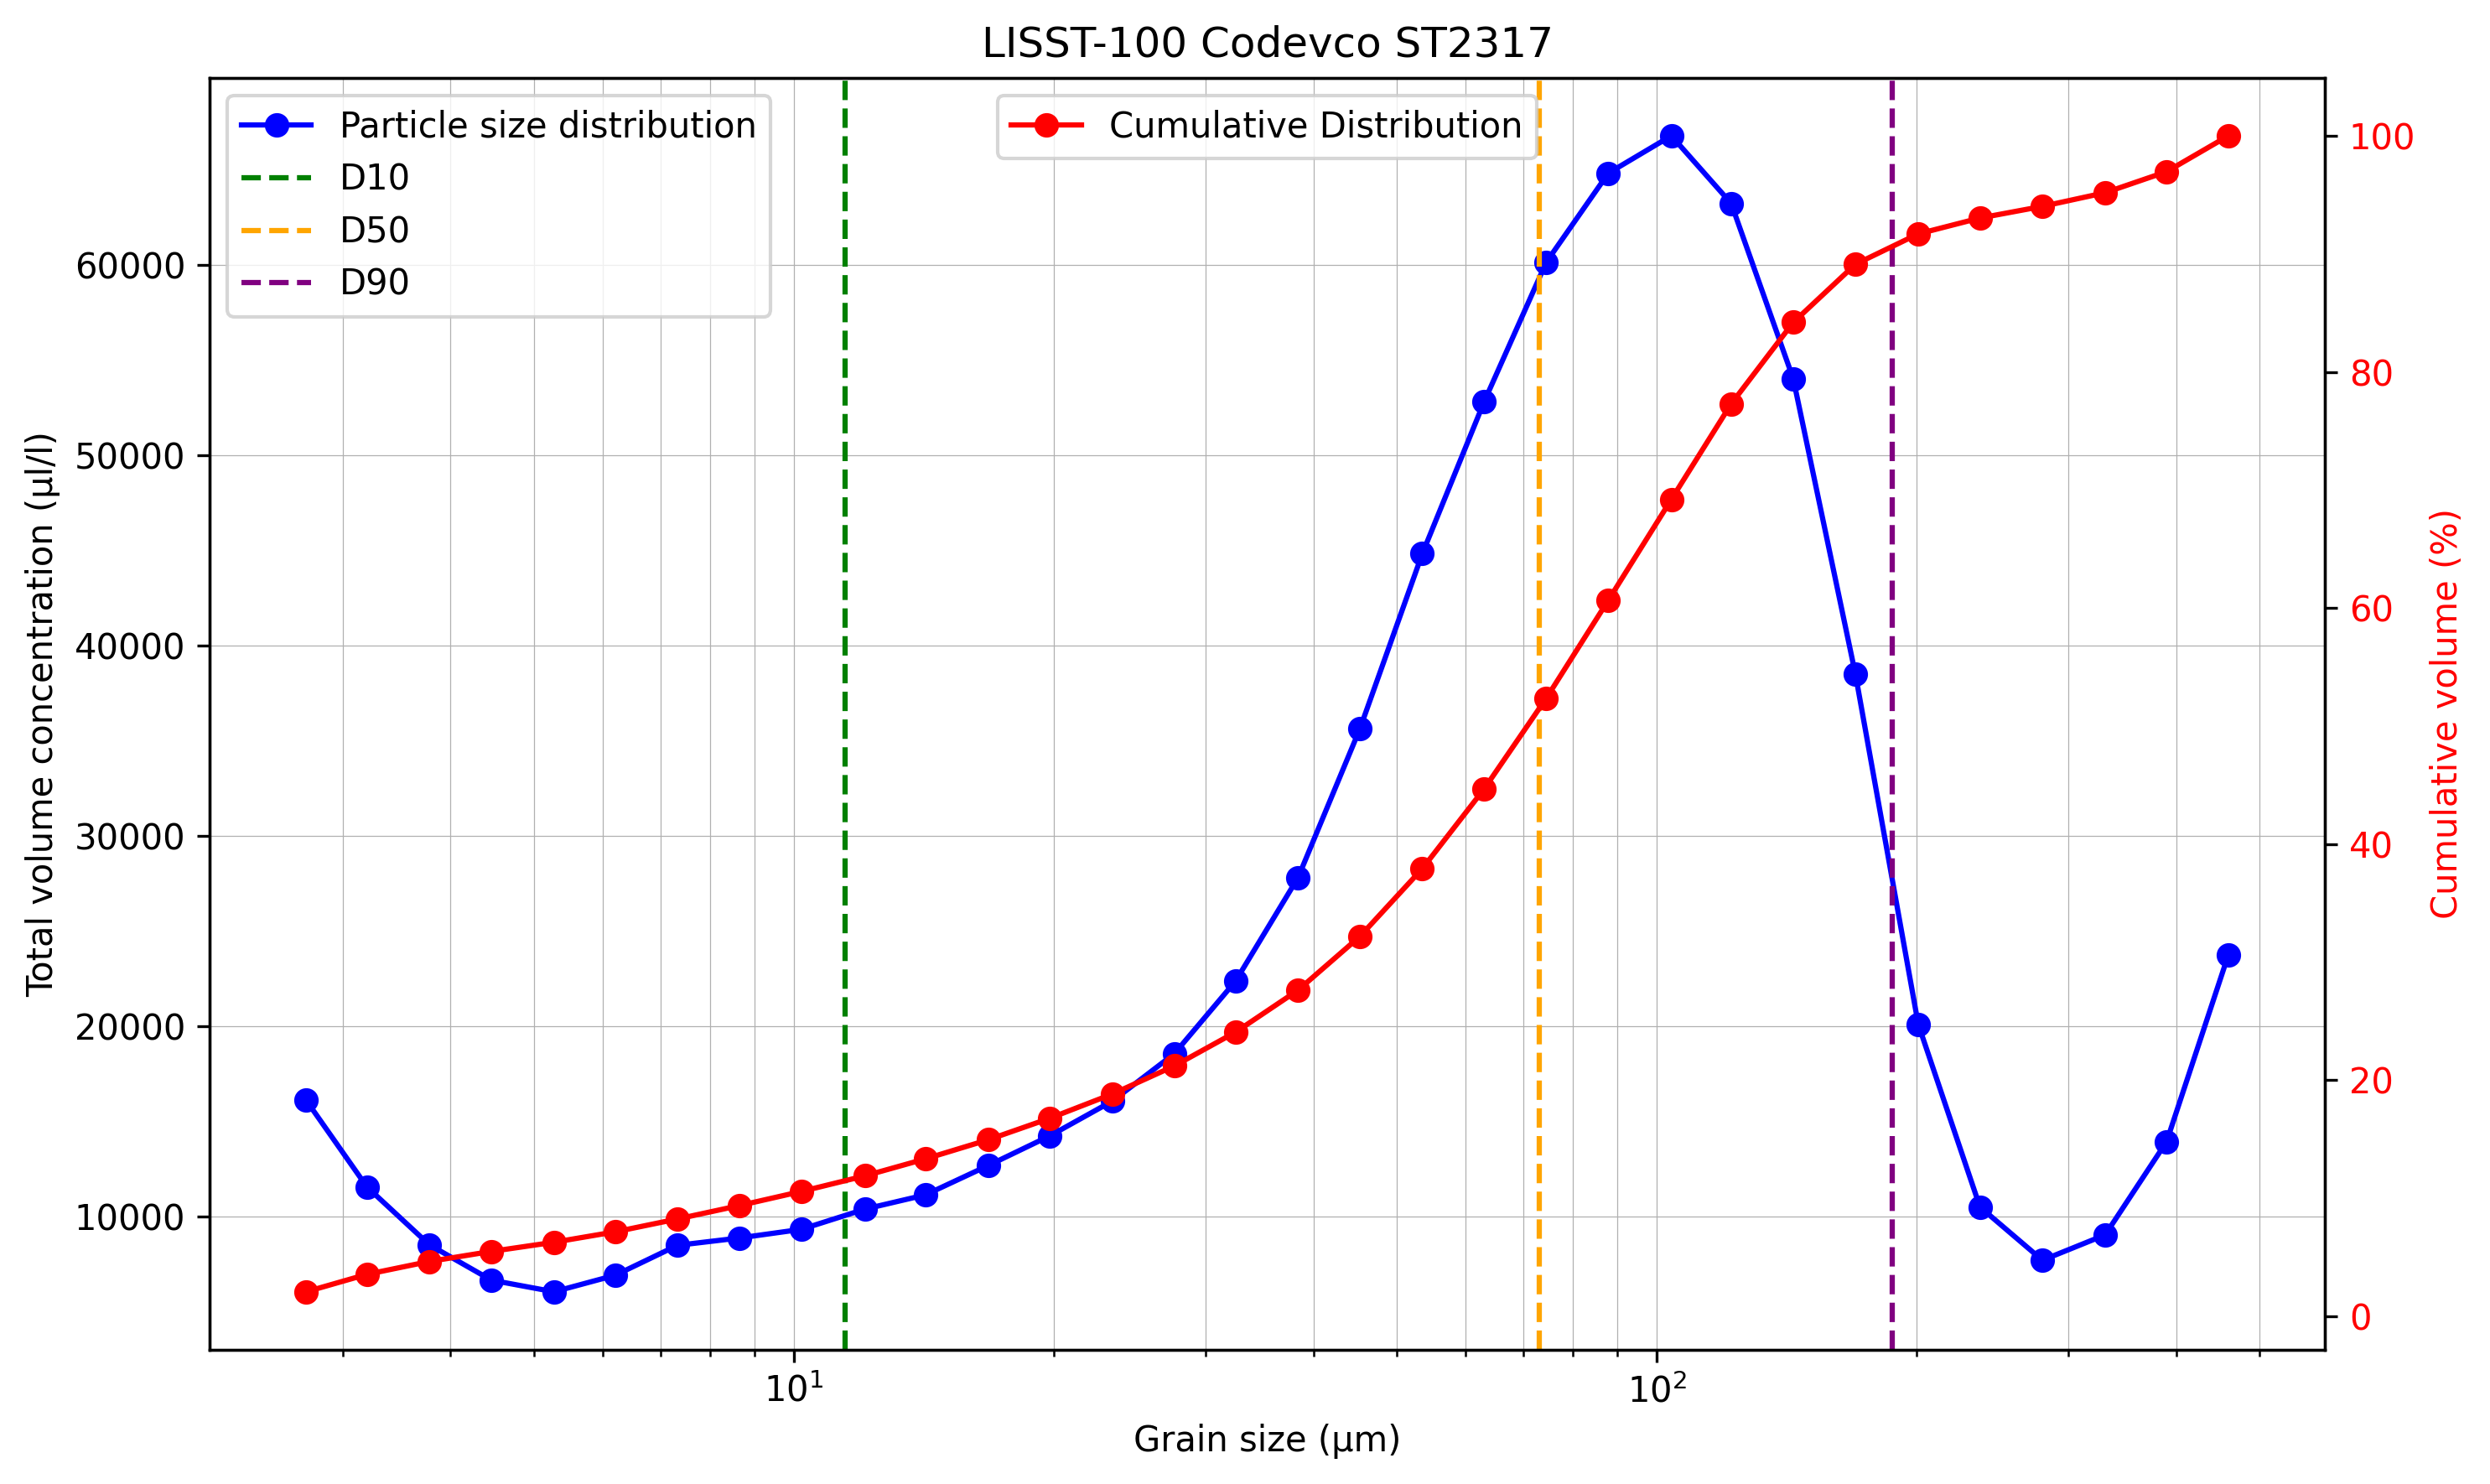

Mean values of calculated parameters for the complete clean dataset:


,Total volume concentration (µl/l),Mean diameter (µm),D10 (µm),D50 (µm),D90 (µm),Span,Standard deviation (µm),Mode (µm)
0,74.972152,91.517484,11.467831,73.084948,187.557466,2.504277,84.088453,104.930411


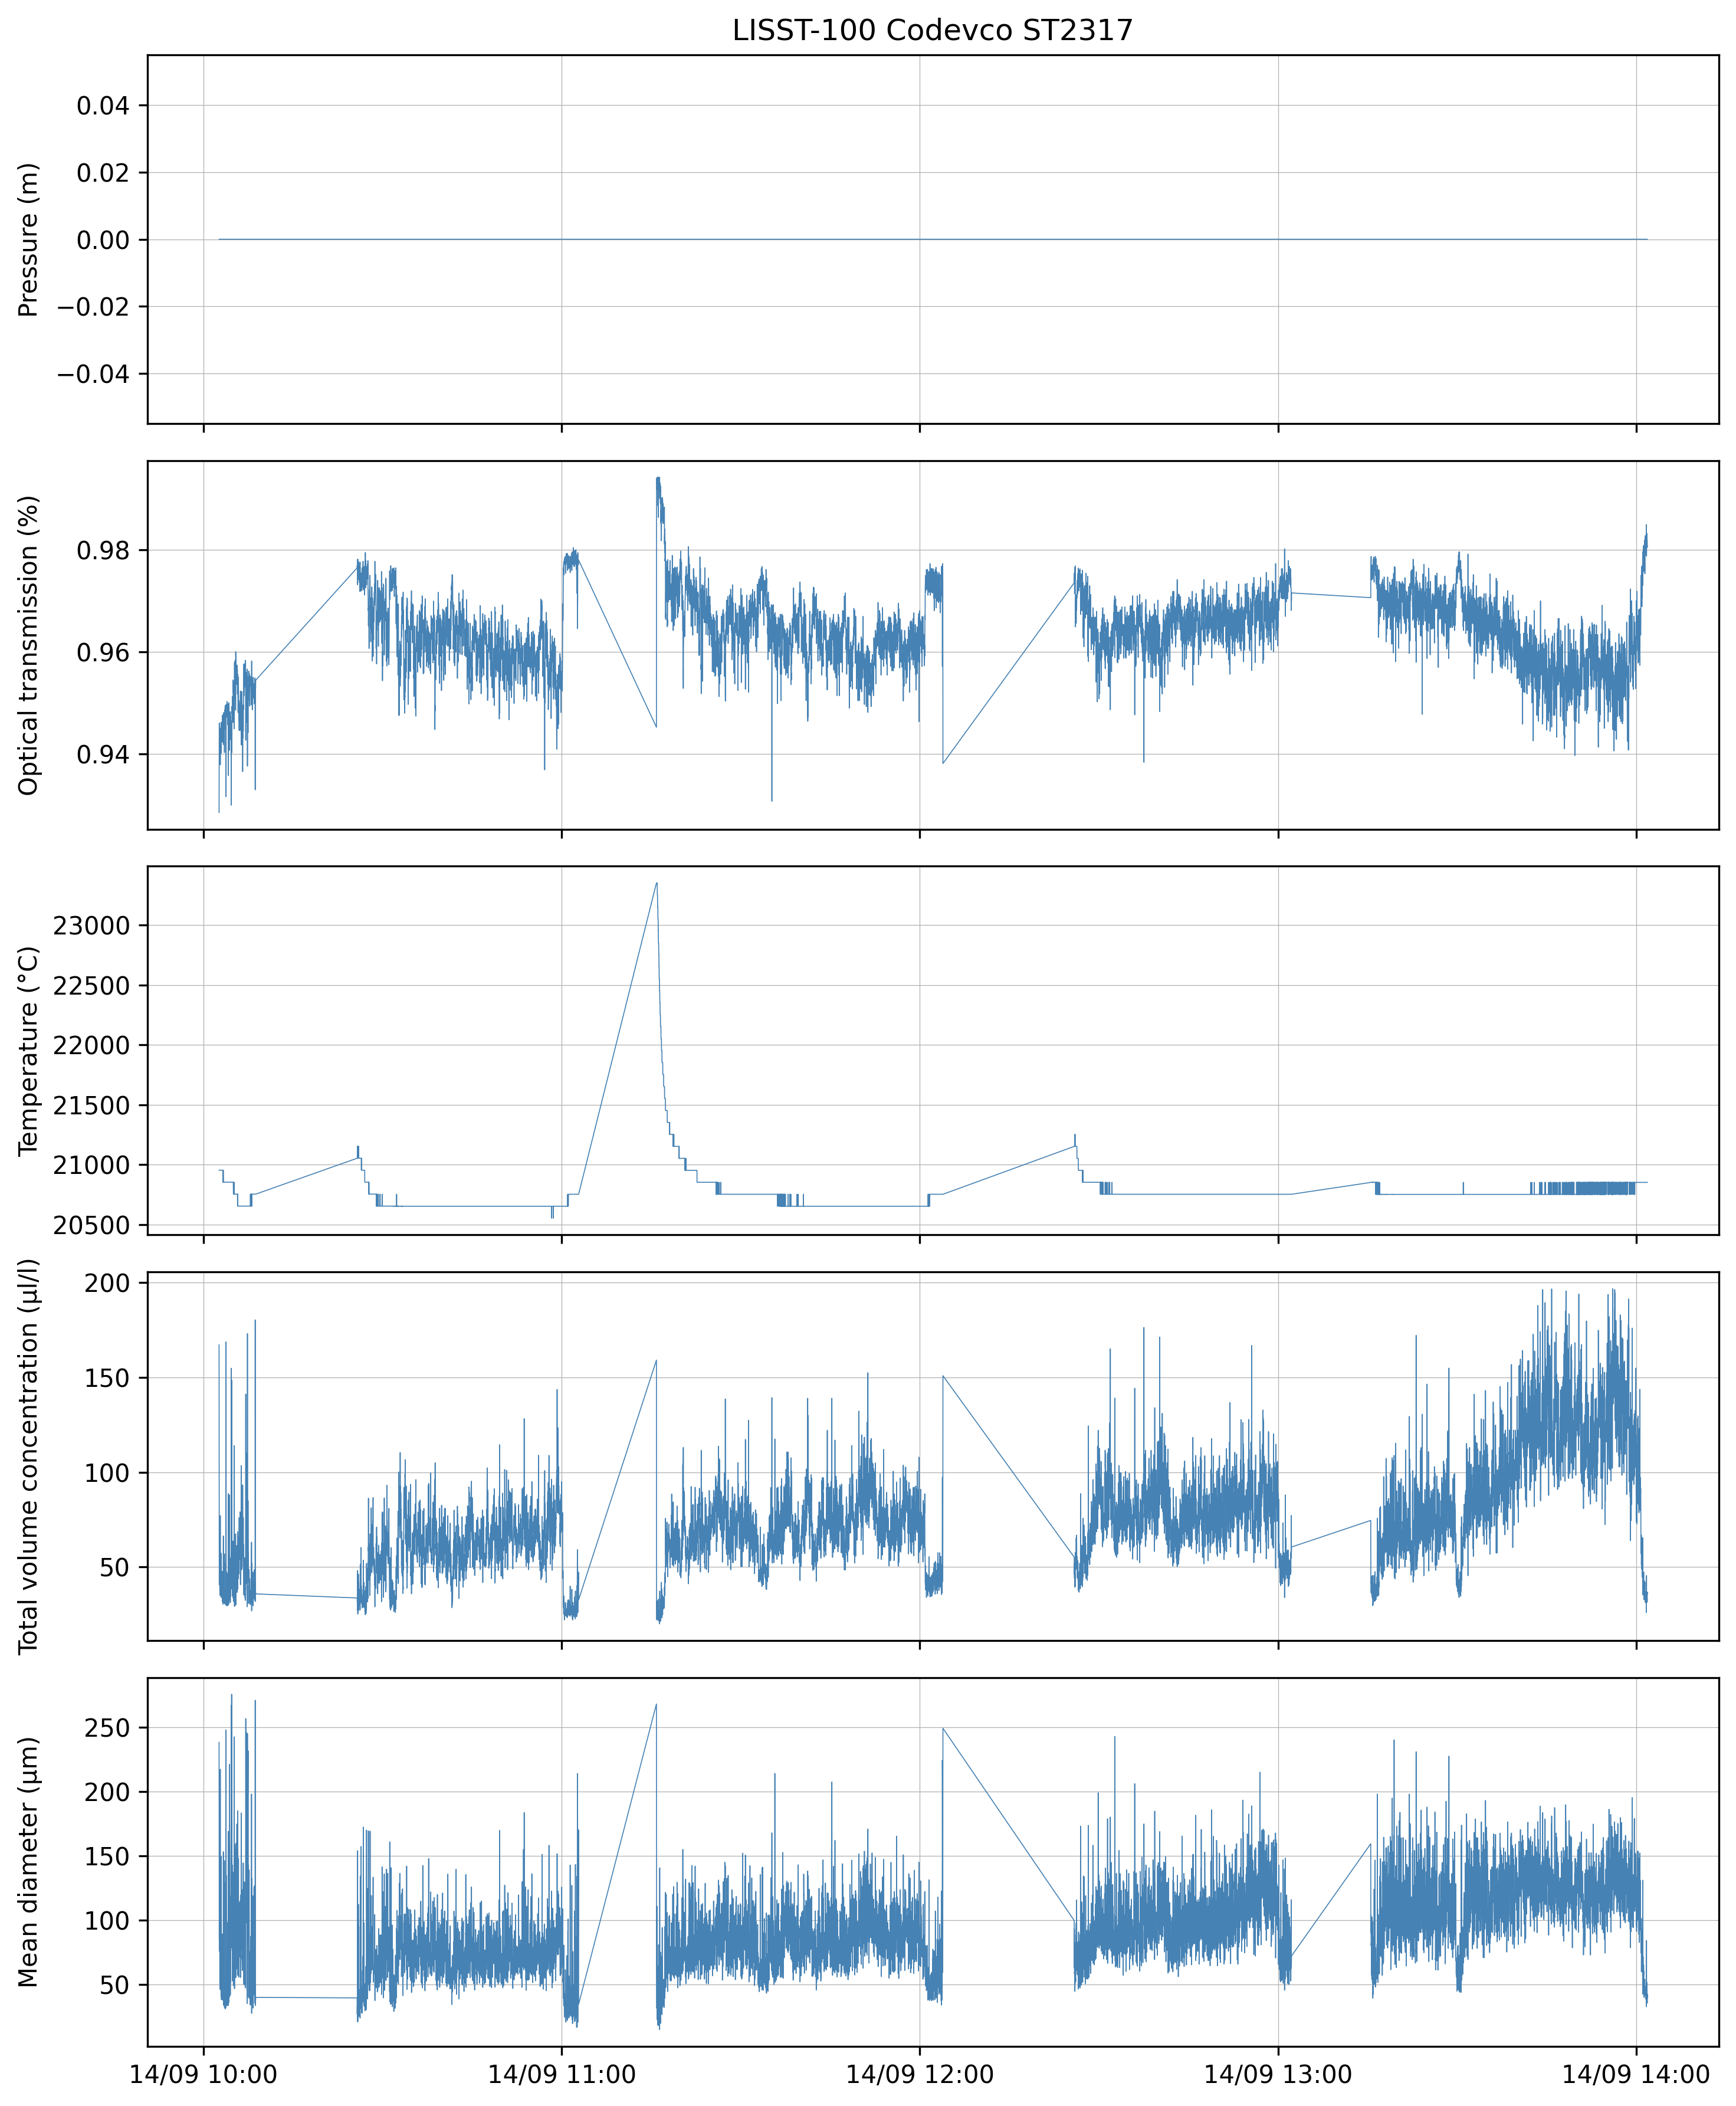

Graphs are saved to: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-100x/test_sample_to_delete/LISST-100-ST2317-Codevco-processed


In [47]:
                                                    ## Cell 07 ##  
# Calculate the total volume concentration 
volume_concentration_columns = ['2.72', '3.2', '3.78', '4.46', '5.27', '6.21', '7.33', '8.65', 
                  '10.2', '12.1', '14.2', '16.8', '19.8', '23.4', '27.6', '32.5', 
                  '38.4', '45.3', '53.5', '63.1', '74.5', '87.9', '104', '122', 
                  '144', '170', '201', '237', '280', '331', '390', '460']
average_volume_fractions = data[volume_concentration_columns].mean()
data['total_volume_concentration_ul_l'] = data[volume_concentration_columns].sum(axis=1)

# Calculate the percentage of each class compared to the total volume concentration
for col in volume_concentration_columns:
    data[f'{col}_%'] = ((data[col] / data['total_volume_concentration_ul_l']) * 100).astype(float)

# Calculate mean diameter 
volume_concentrations = data[volume_concentration_columns].values
grain_sizes = np.array([float(col) for col in volume_concentration_columns])
data['mean_diameter_um'] = np.sum(volume_concentrations * grain_sizes, axis=1) / data['total_volume_concentration_ul_l']

# Cumulative volume concentration
cumulative_volumes = np.cumsum(data[volume_concentration_columns].values, axis=1)

# Percentiles calculation function
def calculate_d_percentile(cumulative_volumes, grain_sizes, total_volume, percentile):
    target = total_volume * (percentile / 100.0)
    d_percentile = []
    for i in range(len(total_volume)):
        if total_volume.iloc[i] == 0: 
            d_percentile.append(np.nan)
        else:
            greater_equal_idx = np.argmax(cumulative_volumes[i, :] >= target.iloc[i])
            d_percentile.append(grain_sizes[greater_equal_idx])
    return np.array(d_percentile)

# Calculate D10, D50, D90
data['D10_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ul_l'], 10)
data['D50_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ul_l'], 50)
data['D90_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ul_l'], 90)

# Calculate the span
data['span'] = (data['D90_um'] - data['D10_um']) / data['D50_um']

# Calculate the standard deviation
def calculate_std(grain_sizes, volume_concentrations, mean_diameter):
    variance = np.sum(volume_concentrations * (grain_sizes - mean_diameter[:, None])**2, axis=1) / np.sum(volume_concentrations, axis=1)
    return np.sqrt(variance)
data['std_dev_um'] = calculate_std(grain_sizes, volume_concentrations, data['mean_diameter_um'].values)

# Calculate the mode
def calculate_mode(grain_sizes, volume_concentrations):
    mode_values = []
    for vc in volume_concentrations:
        if np.all(vc == 0):
            mode_values.append(np.nan)
        else:
            mode_index = np.argmax(vc)
            mode_values.append(grain_sizes[mode_index])
    return np.array(mode_values)
data['mode_um'] = calculate_mode(grain_sizes, volume_concentrations)

# Identify peaks in the distribution 
def find_all_peaks(grain_sizes, volume_concentrations):
    all_peaks = []
    for vc in volume_concentrations:
        if np.all(vc == 0):
            all_peaks.append([])
        else:
            peaks, _ = find_peaks(vc)
            peak_sizes = grain_sizes[peaks]
            all_peaks.append(peak_sizes.tolist())
    return all_peaks
data['peaks'] = find_all_peaks(grain_sizes, volume_concentrations)

# Display updated dataframe
print('Statistics have been successfully computed')
display(data)

# Display the histogram of the particle size distribution and the cumulative volume distribution (in red)
total_volume_concentration_per_class = data[volume_concentration_columns].sum(axis=0)
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
ax1.plot(grain_sizes, total_volume_concentration_per_class, color='blue', marker='o', 
         label='Particle size distribution', linestyle='-')
ax1.set_xscale('log')
ax1.set_xlabel('Grain size (µm)')
ax1.set_ylabel('Total volume concentration (µl/l)')
ax1.set_title(f'LISST-100 {location} {campaign_code}')
ax1.grid(axis='both', which='both', linewidth=0.3)
cumulative_volumes = np.cumsum(total_volume_concentration_per_class)
ax2 = ax1.twinx() 
ax2.plot(grain_sizes, cumulative_volumes / cumulative_volumes[-1] * 100, color='red', 
         label='Cumulative Distribution', marker='o')
ax2.set_ylabel('Cumulative volume (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.axvline(data['D10_um'].mean(), color='green', linestyle='--', label='D10')
ax1.axvline(data['D50_um'].mean(), color='orange', linestyle='--', label='D50')
ax1.axvline(data['D90_um'].mean(), color='purple', linestyle='--', label='D90')
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
plt.tight_layout()
plt.show()
graph_file_path = f"{output_directory}/{campaign_code}-{location}-LISST100-full-PSD.png"
fig.savefig(graph_file_path) 

# Display table with the mean of each parameter
mean_values = {
    'Total volume concentration (µl/l)': data['total_volume_concentration_ul_l'].mean(),
    'Mean diameter (µm)': data['mean_diameter_um'].mean(),
    'D10 (µm)': data['D10_um'].mean(),
    'D50 (µm)': data['D50_um'].mean(),
    'D90 (µm)': data['D90_um'].mean(),
    'Span': data['span'].mean(),
    'Standard deviation (µm)': data['std_dev_um'].mean(),
    'Mode (µm)': data['mode_um'].mean()
}
mean_values_df = pd.DataFrame(mean_values, index=[0])
print('Mean values of calculated parameters for the complete clean dataset:')
display(mean_values_df)

fig, axs = plt.subplots(5, 1, figsize=(10, 12), dpi=300, sharex=True)
axs[0].set_title(f'LISST-100 {location} {campaign_code}')
axs[0].plot(data['datetime'], data['pressure_m'], color='steelblue', linestyle='-', linewidth=0.4)
axs[0].set_ylabel('Pressure (m)')
axs[0].grid(axis='both', which='both', linewidth=0.3)
axs[1].plot(data['datetime'], data['optical_transmission'], color='steelblue', linestyle='-', linewidth=0.4)
axs[1].set_ylabel('Optical transmission (%)')
axs[1].grid(axis='both', which='both', linewidth=0.3)
axs[2].plot(data['datetime'], data['temperature_C'], color='steelblue', linestyle='-', linewidth=0.4)
axs[2].set_ylabel('Temperature (°C)')
axs[2].grid(axis='both', which='both', linewidth=0.3)
axs[3].plot(data['datetime'], data['total_volume_concentration_ul_l'], color='steelblue', linestyle='-', linewidth=0.4)
axs[3].set_ylabel('Total volume concentration (µl/l)')
axs[3].grid(axis='both', which='both', linewidth=0.3)
axs[4].plot(data['datetime'], data['mean_diameter_um'], color='steelblue', linestyle='-', linewidth=0.4)
axs[4].set_ylabel('Mean diameter (µm)')
axs[4].grid(axis='both', which='both', linewidth=0.3)
axs[4].set_xlabel('')
axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
axs[4].xaxis.set_major_locator(mdates.HourLocator(interval=1))
fig.align_ylabels()
plt.tight_layout()
plt.show()
graph_file_path = f"{output_directory}/{campaign_code}-{location}-LISST100-g-full-graph2.png"
fig.savefig(graph_file_path) 

# Save output
print(f'Graphs are saved to: {output_directory}')
                                                        ###

#### Stage 3 - Step 2: Removal of suspicious data & creation of a 'clean' dataset

This step allows the user to choose a certain flag threshold at and above which data are discarded for further analysis. The default value is set to 4, meaning all data flagged 4 and above will be removed from the filtered dataframe. In this cell, values considered outliers can also be removed.

In [19]:
                                                    ## Cell 06 ##
try:
    threshold = int(input("Enter the threshold for flag filtration (default is 4): ") or 4)
except ValueError:
    print("Invalid input, defaulting to threshold = 4.")
    threshold = 4
    
outliers = input("Remove outliers (yes or no): ")

# Filter out rows where flag is greater than or equal to the chosen threshold
filtered_data = data[data['flag'] < threshold]

# Filter out ouliers
if outliers == 'yes' or outliers == 'Yes':
    filtered_data = filtered_data[filtered_data['is_outlier'] != True]
elif outliers == 'no' or outliers == 'No':
    filtered_data = filtered_data
else:
    print("Invalid input, outliers were not filtered out.")

# Display the filtered data
print(f"After filtering, the dataset is:")
display(filtered_data)

# Save filtered data as csv
filtered_data_path = f"{output_directory}/{campaign_code}-{location}-LISST100-clean-data.csv"
filtered_data.to_csv(filtered_data_path, index=False)
                                                        ###

Enter the threshold for flag filtration (default is 4): 4
Remove outliers (yes or no): yes
After filtering, the dataset is:


,2.72,3.2,3.78,4.46,5.27,6.21,7.33,8.65,10.2,12.1,...,390_%,460_%,mean_diameter_um,D10_um,D50_um,D90_um,span,std_dev_um,mode_um,peaks
513,7.12088,2.870700,0.921646,0.297726,0.171914,0.279974,0.613128,0.726412,0.913216,1.305070,...,19.576785,5.930018,238.263748,16.80,280.0,390.0,1.332857,143.947020,331.00,"[12.1, 16.8, 27.6, 144.0, 331.0]"
514,6.65700,2.777140,0.934894,0.319186,0.193705,0.318252,0.679022,0.789028,0.969562,1.364092,...,6.897668,1.680228,173.676969,3.78,170.0,331.0,1.924824,133.447485,331.00,"[12.1, 16.8, 170.0, 331.0]"
515,6.20142,2.601380,0.882004,0.305768,0.190198,0.317604,0.674484,0.768794,0.929186,1.279692,...,1.289039,8.175758,85.207885,2.72,27.6,280.0,10.046377,129.849772,2.72,"[12.1, 16.8, 27.6, 53.5, 122.0]"
516,5.47990,2.491080,0.938862,0.364250,0.241542,0.390464,0.774110,0.859502,0.998730,1.313834,...,3.598609,11.837185,122.635417,2.72,53.5,460.0,8.547290,152.694484,460.00,"[12.1, 16.8, 27.6, 144.0]"
517,5.00538,2.355080,0.928272,0.377820,0.258372,0.411470,0.785636,0.859366,0.994898,1.304294,...,2.773181,18.289022,132.602895,2.72,38.4,460.0,11.908333,173.025074,460.00,"[12.1, 16.8, 27.6, 53.5, 122.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14866,4.31188,1.862852,0.658638,0.233810,0.142430,0.225268,0.465862,0.547266,0.669012,0.914118,...,0.000000,0.091645,46.454113,2.72,38.4,104.0,2.637500,42.185172,2.72,"[12.1, 74.5]"
14867,4.57820,1.919792,0.653462,0.223394,0.133435,0.214516,0.454836,0.535816,0.661774,0.924832,...,0.009198,0.146582,45.101715,2.72,32.5,104.0,3.116308,43.435416,2.72,"[12.1, 19.8, 63.1]"
14868,5.04242,1.987552,0.621856,0.193561,0.108462,0.176388,0.394836,0.483288,0.629298,0.933688,...,0.000000,0.048375,39.452384,2.72,27.6,87.9,3.086232,38.771997,2.72,"[19.8, 53.5]"
14869,5.63722,2.134120,0.634158,0.186253,0.100720,0.166428,0.386966,0.480438,0.630880,0.945208,...,0.000000,0.081466,42.650573,2.72,32.5,104.0,3.116308,40.115523,2.72,[63.1]


#### Stage 3 - Step 3: Division of the clean dataset into casts

In this cell, a cast letter will be attributed to each set of consecutive values separated from the previous set by a certain time interval. The latter has to be decided by the user (in minutes). If needed, this time difference can be adapted in the code directly (line 8). If the user has other data available for these casts, we advise comparing their timings to the table generated in this cell.

In [24]:
                                                    ## Cell 08 ##
cast_interval = int(input("Enter the expected cast interval (in minutes): "))    
    
data = filtered_data if not filtered_data.empty else data

current_cast = 'A'
cast_numbers = [current_cast]

# Loop through the dataset and check the time difference between consecutive rows
for i in range(1, len(data)):
    time_diff = data['datetime'].iloc[i] - data['datetime'].iloc[i - 1]
    # If the time difference is greater than or equal to expected time interval, increment the cast value
    if time_diff >= timedelta(minutes=cast_interval):
        current_cast = chr(ord(current_cast) + 1)
    cast_numbers.append(current_cast)

# Add the cast numbers as a new column in the dataframe
data.loc[:, 'cast'] = cast_numbers

# Group by the cast to find the start and stop time for each cast
summary_table = data.groupby('cast').agg(
    datetime_start=('datetime', 'min'),
    datetime_stop=('datetime', 'max')
).reset_index()

# Display the summary table
print('Summary of casts timings (clean data):')
display(summary_table)
                                                        ###

Enter the expected cast interval (in minutes): 10
Summary of casts timings (clean data):


,cast,datetime_start,datetime_stop
0,A,2023-09-14 10:02:38,2023-09-14 10:08:46
1,B,2023-09-14 10:25:45,2023-09-14 11:02:51
2,C,2023-09-14 11:15:53,2023-09-14 12:03:52
3,D,2023-09-14 12:25:51,2023-09-14 13:02:15
4,E,2023-09-14 13:15:31,2023-09-14 14:01:51


#### Stage 3 - Step 4: Comparison of the different casts

This cell generates a table and several graphs comparing the different casts of the processed dataset. These are saved in the directory previously selected by the user, together with a csv containing the mean values of each cast.

Summary table saved to: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-100x/test_sample_to_delete/LISST-100-ST2317-Codevco-processed/ST2317-Codevco-LISST100-cast-summary.csv
Statistics per cast:


,cast,datetime_start,datetime_stop,mean_total_volume_concentration,mean_diameter,mean_D10,mean_D50,mean_D90,mean_span,mean_std_dev,mean_mode
0,A,2023-09-14 10:02:38,2023-09-14 10:08:46,47.470080,86.619887,4.415249,57.698895,220.361326,4.542734,93.690822,146.880497
1,B,2023-09-14 10:25:45,2023-09-14 11:02:51,58.984718,69.775716,6.877869,55.526754,141.445459,2.650635,68.227077,85.586430
2,C,2023-09-14 11:15:53,2023-09-14 12:03:52,68.443161,81.266926,9.156774,63.951163,163.369340,2.447515,78.742637,93.756979
3,D,2023-09-14 12:25:51,2023-09-14 13:02:15,76.711670,98.844190,12.528508,79.662792,200.041190,2.321306,89.456790,110.331350
4,E,2023-09-14 13:15:31,2023-09-14 14:01:51,96.771305,114.442334,17.627547,93.456664,235.490814,2.324107,96.864308,122.298393


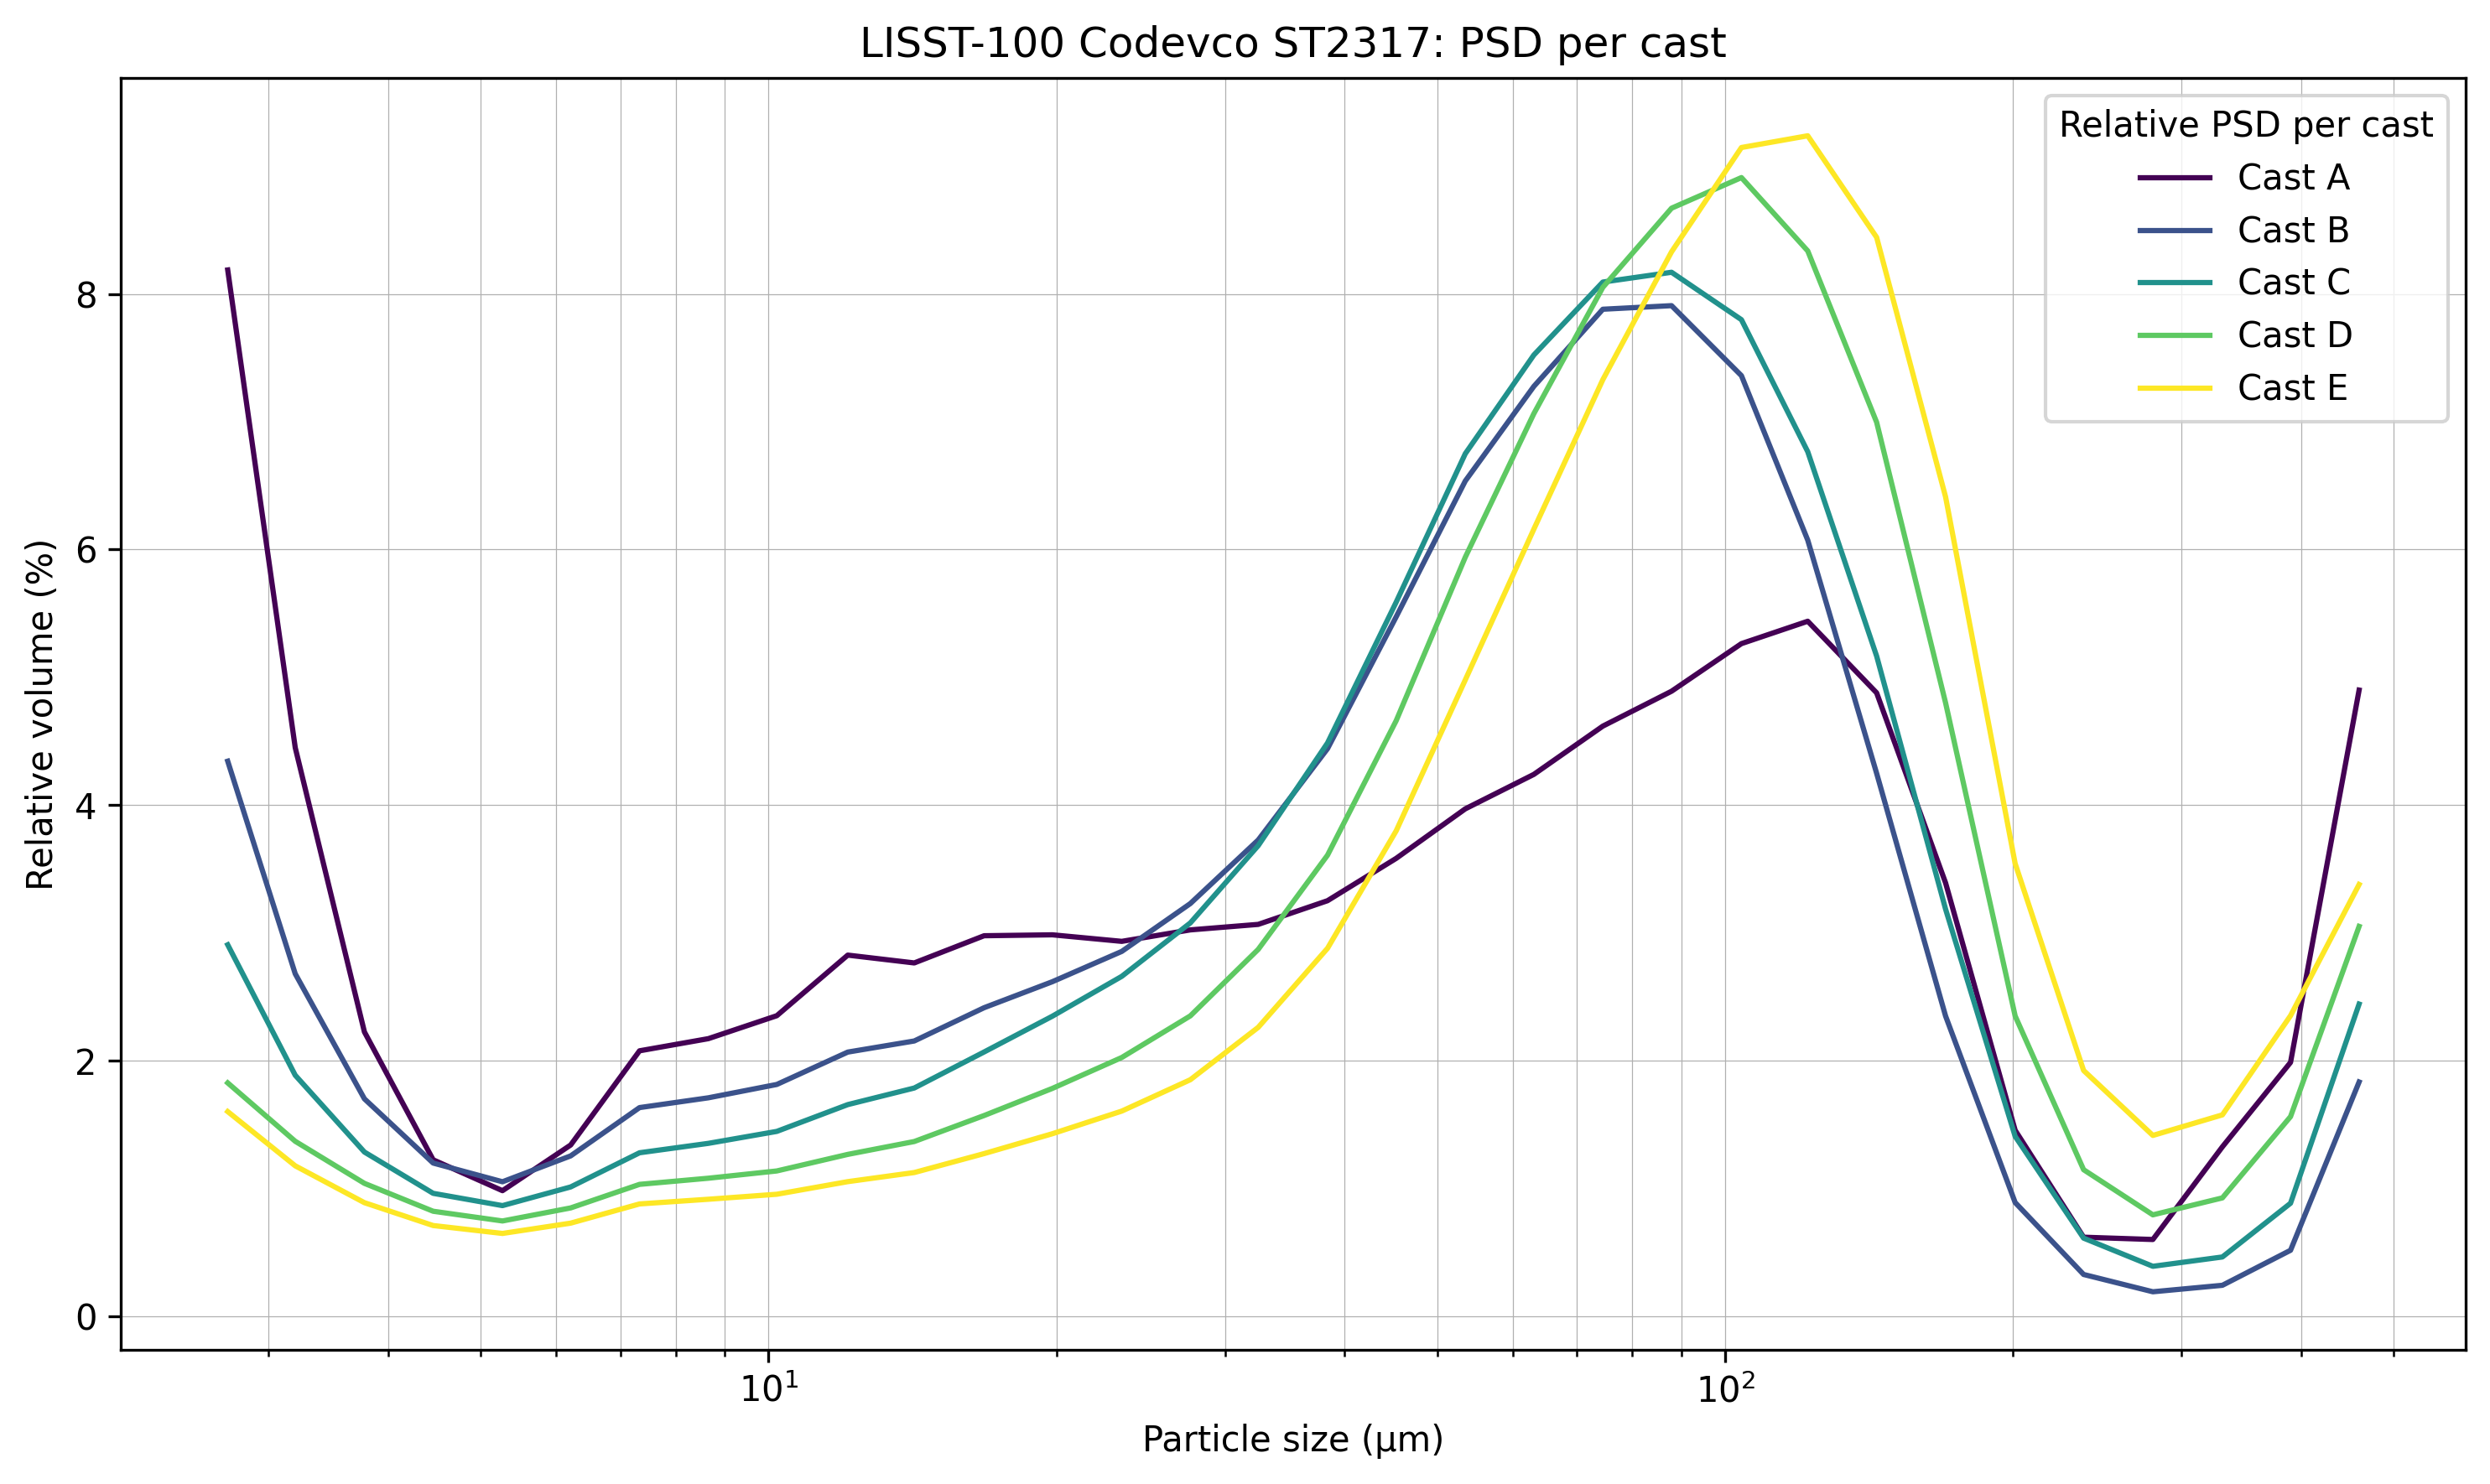

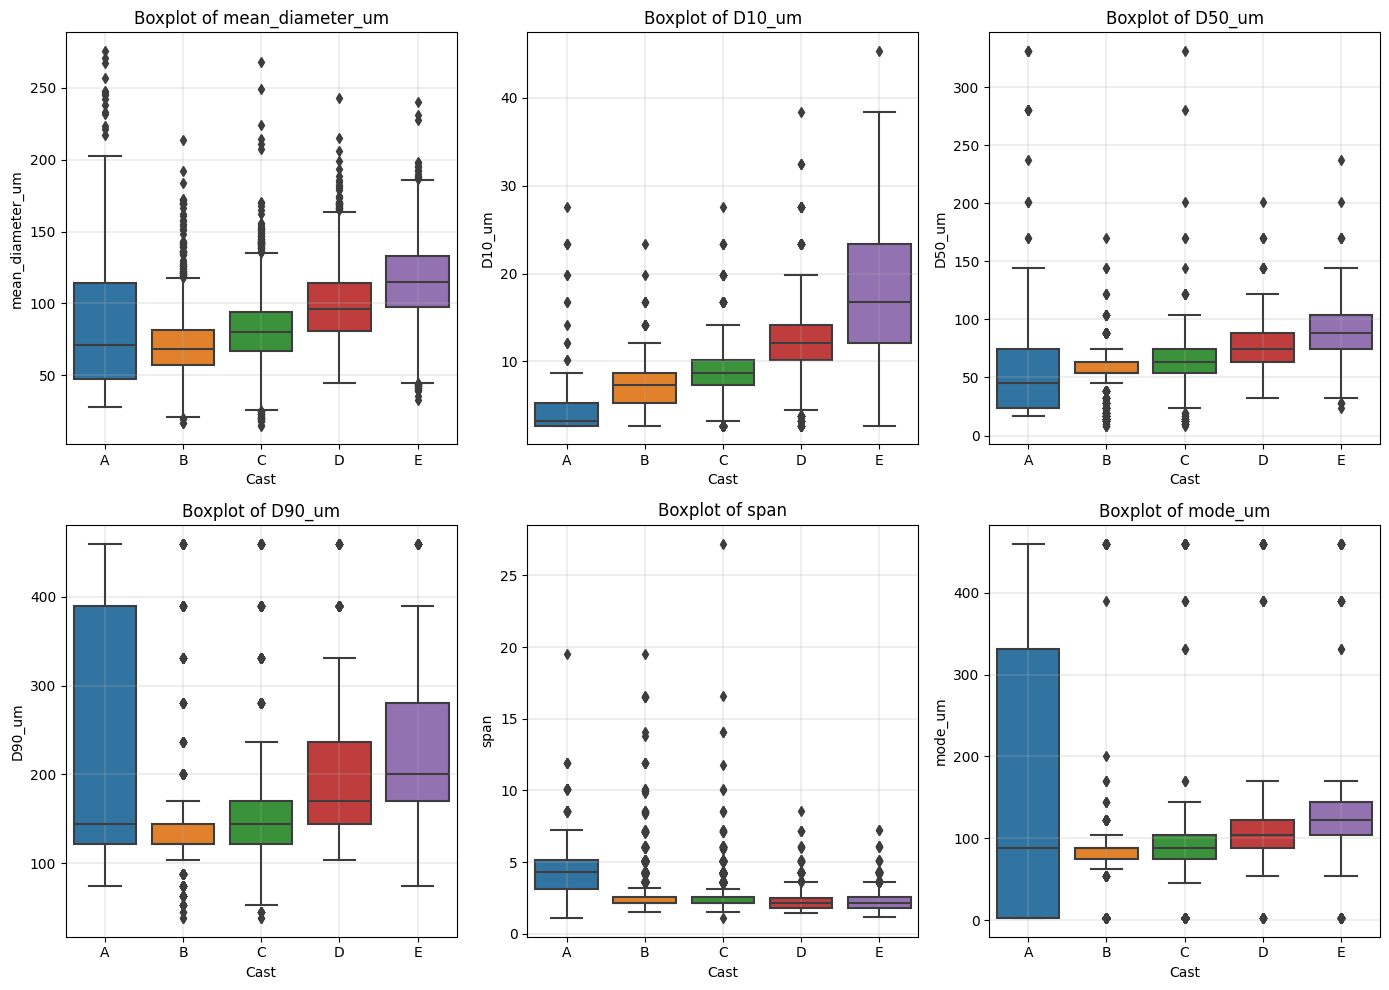

In [25]:
                                                    ## Cell 09 ##
data = filtered_data if not filtered_data.empty else data
    
# Create summary table per cast with mean values
summary_table = data.groupby('cast').agg(
    datetime_start=('datetime', 'min'),
    datetime_stop=('datetime', 'max'),
    mean_total_volume_concentration=('total_volume_concentration_ul_l', 'mean'),
    mean_diameter=('mean_diameter_um', 'mean'),
    mean_D10=('D10_um', 'mean'),
    mean_D50=('D50_um', 'mean'),
    mean_D90=('D90_um', 'mean'),
    mean_span=('span', 'mean'),
    mean_std_dev=('std_dev_um', 'mean'),
    mean_mode=('mode_um', 'mean'),
).reset_index()
summary_table_path = f"{output_directory}/{campaign_code}-{location}-LISST100-cast-summary.csv"
summary_table.to_csv(summary_table_path, index=False)
print(f"Summary table saved to: {summary_table_path}")

unique_casts = data['cast'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_casts)))

# Display the summary table
print("Statistics per cast:")
display(summary_table)

# Plot the relative PSD for each cast
plt.figure(figsize=(10, 6), dpi=300)
volume_columns_percentage = [
    '2.72_%', '3.2_%', '3.78_%', '4.46_%', '5.27_%', 
    '6.21_%', '7.33_%', '8.65_%', '10.2_%', '12.1_%', 
    '14.2_%', '16.8_%', '19.8_%', '23.4_%', '27.6_%', 
    '32.5_%', '38.4_%', '45.3_%', '53.5_%', '63.1_%', 
    '74.5_%', '87.9_%', '104_%', '122_%', '144_%', 
    '170_%', '201_%', '237_%', '280_%', '331_%', 
    '390_%', '460_%'
]
for i, cast in enumerate(unique_casts):
    cast_data = data[data['cast'] == cast]
    volume_concentration_percentage = cast_data[volume_columns_percentage].mean(axis=0).values
    plt.plot(grain_sizes, volume_concentration_percentage, label=f'Cast {cast}', color=colors[i])
plt.title(f'LISST-100 {location} {campaign_code}: PSD per cast')
plt.xlabel('Particle size (µm)')
plt.ylabel('Relative volume (%)')
plt.legend(title='Relative PSD per cast')
plt.grid(axis='both', which='both', linewidth=0.3)
plt.xscale('log') 
plt.tight_layout()
psd_plot_path = f"{output_directory}/{campaign_code}-{location}-LISST100-PSD-per-cast.png"
plt.savefig(psd_plot_path, bbox_inches='tight')
plt.show()

# Plot comparison of different parameters between casts
parameters = ['mean_diameter_um', 'D10_um', 'D50_um', 'D90_um', 'span', 'mode_um']
plt.figure(figsize=(14, 10))
for i, param in enumerate(parameters):
    plt.subplot(2, 3, i + 1) 
    sns.boxplot(data=data, x='cast', y=param)
    plt.title(f'Boxplot of {param}')
    plt.xlabel('Cast')
    plt.ylabel(param)
    plt.grid(axis='both', which='both', linewidth=0.3)
plt.tight_layout()
psd_plot2_path = f"{output_directory}/{campaign_code}-{location}-LISST100-cast-comparison.png"
plt.savefig(psd_plot2_path, bbox_inches='tight')
plt.show()
                                                        ###